In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
import math

In [2]:
data_path = "data/"
places = pd.read_csv(data_path + "places_final.csv", sep=",")
reviews = pd.read_csv(data_path + "reviews_final.csv", sep=",")

## Datafram preperation

To create a dataframe which can be used for space embedding in London and New York, the features for both cities are aggregated on a grid cell level. 

### Business per grid cell

Counting all business per cell

In [3]:
df_grid=places.groupby('Grid')['gPlusPlaceId'].count().reset_index()
df_grid.rename(columns = {'gPlusPlaceId':'PlaceCount'}, inplace = True)

Finding the avg price range for businesses in the grid cells

In [4]:
price = places.groupby('Grid').mean()['price'].reset_index()
df_grid=df_grid.merge(price,on='Grid')

Counting number of business per category per grid cell

In [5]:
cat_cols=places.groupby(['Grid','category']).count()['gPlusPlaceId'].reset_index()
cat_cols=pd.pivot_table(cat_cols, index='Grid', columns='category', values='gPlusPlaceId').fillna(0)
df_grid=df_grid.join(cat_cols,on='Grid')

In [8]:
df_grid.head()

,Grid,PlaceCount,price,Accommodation,Bar,Cafe,Cultural,Education,Health,Other,Outdoors,Restaurant,Retail,Service,Wholesale
0,L0,8,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,1.0,0.0
1,L1,10,2.000000,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,2.0,1.0
2,L10,3,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,L100,74,2.235294,12.0,6.0,6.0,0.0,1.0,4.0,16.0,0.0,17.0,4.0,7.0,1.0
4,L101,163,1.953488,21.0,19.0,20.0,1.0,1.0,10.0,19.0,0.0,37.0,21.0,9.0,5.0


### Rating

Finding number of reviews per cell

In [9]:
mergeddf=places.merge(reviews,on='gPlusPlaceId',how='outer').dropna(subset=['name'])
grid_reviews = mergeddf.groupby('Grid').count()['gPlusUserId'].reset_index()
df_grid=df_grid.merge(grid_reviews,on='Grid')

Overall average rating per cell, and average per budiness type

When finding the average ratings, all business with less than 3 reviews are removed, as these tend to have a very large average review. 
A reason for this could be that friends and family give good ratings to newly opened businesses.

In [12]:
mergeddf['rating'] = mergeddf['rating'].astype(float)
# removing all business with less than 3 reviews
avg_reviews = mergeddf.groupby(['Grid','gPlusPlaceId'])['rating'].agg(["count", "mean"]).loc[lambda x: x['count'] > 3, "mean"].reset_index()

# finding the average rating per grid cell
avg_reviews = avg_reviews.groupby('Grid').mean()['mean'].reset_index()

df_grid=df_grid.merge(avg_reviews,on='Grid')

In [14]:
#Creating rating name column for each business type's avg rating 

cat_rev = mergeddf.groupby(['Grid','category','gPlusPlaceId'])['rating'].agg(["count", "mean"]).loc[lambda x: x['count'] > 3, "mean"].reset_index()
cat_val=[]

for i in range(len(cat_rev)):
    cat_val.append(cat_rev['category'][i]+'_rating')

cat_rev['cat_val']=cat_val
category_rating=pd.pivot_table(cat_rev, index='Grid', columns='cat_val', values='mean').fillna(0)
df_grid=df_grid.merge(category_rating,on='Grid')

### Sensitivity

Counting positive and negative reviews in a grid cell

In [16]:
positive=np.zeros(len(mergeddf))
negative=np.zeros(len(mergeddf))
#neutral=np.zeros(len(mergeddf))

for i in range(len(mergeddf)):
    sensitiv=[mergeddf['posReviewPercent'][i],mergeddf['negReviewPercent'][i]]#,mergeddf['midReviewPercent'][i]]
    sensitivmax=np.where(sensitiv==np.max(sensitiv))[0]
    
    if math.isnan(sensitiv[0])==False:
        if 0 in sensitivmax:
            positive[i]=1

        if 1 in sensitivmax:
            negative[i]=1   

#        if 2 in sensitivmax:
#            neutral[i]=1
    else:
        0

mergeddf['positive'] = positive
mergeddf['negative'] = negative
#mergeddf['neutral'] = neutral

In [17]:
# Sum of positiv and negative ratings per grid cell

sensitivity = mergeddf.groupby('Grid').sum()[['positive','negative']].reset_index()

# Total number of positive and negative ratings in dataframe
count=sensitivity.iloc[:,1:].sum(axis=1)

# distribution of positive and negative reviews per grid cell
sensitivity['positive']=sensitivity['positive']/count
sensitivity['negative']=sensitivity['negative']/count

df_grid=df_grid.merge(sensitivity,on='Grid')

Relative review length per grip cell (Avg length per cell over evg length for all reviews)

In [19]:
review_len=[]
for i in range(len(mergeddf)):
    if pd.isnull(mergeddf['reviewText'][i])==False:
        review_len.append(len(mergeddf['reviewText'][i].split(" ")))
    else: 
        review_len.append(0)
        

mergeddf['review_len']=review_len   
avg_review_len = np.mean(review_len)

In [20]:
Grid_review_len = mergeddf.groupby('Grid').mean()['review_len'].reset_index()
Grid_review_len['review_len'] = Grid_review_len['review_len']/avg_review_len
df_grid=df_grid.merge(Grid_review_len,on='Grid')

Final dataframe for grid cell aggregated features

In [21]:
df_grid.head()

,Grid,PlaceCount,price,Accommodation,Bar,Cafe,Cultural,Education,Health,Other,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,positive,negative,review_len
0,L0,8,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,2.000000,0.0,0.0,1.0,0.0,0.0,1.0,3.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,2.235294,12.0,6.0,6.0,0.0,1.0,4.0,16.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,1.953488,21.0,19.0,20.0,1.0,1.0,10.0,19.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


## Uniform Discretized Data Transformation 

In [2]:
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from matplotlib.pyplot import figure
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
import pandas as pd
df = pd.read_csv("data/space_embedding_data.csv", index_col=[0])
df.head()

,Grid,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,PositiveReviews,NegativeReviews,ReviewLength
0,L0,8,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,0,1,0,0.0,0.0,1.0,0.0,0.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,2,9,6,12.0,6.0,6.0,0.0,1.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,7,31,5,21.0,19.0,20.0,1.0,1.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


Plotting the current distribution of all features

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


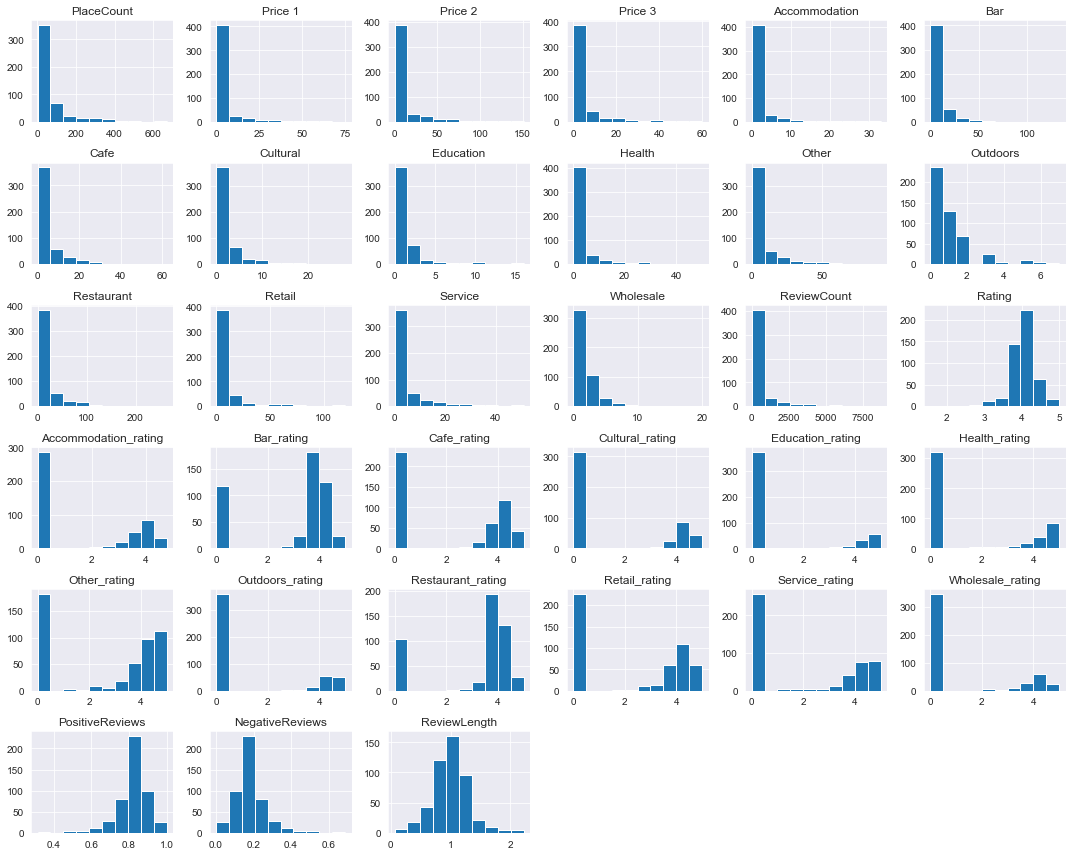

In [4]:
fig = plt.figure(figsize = (15,12))
ax = fig.gca()
df.hist(ax = ax)
#fig.show()
plt.tight_layout()

Defining a function for uniform discretizing of the features

Can only handle features with less than 20% zero values. 

the minimum number og bins are set to 3 and the maximum number of bins are 10. If the dataset contains 0's the maximum number of bins is set depending on the amount of zeros

In [26]:
def uniform_Discretization(array):
    minspan = []
    
    # max number og bins is 10 (5+3)
    max_bins = 7
    #if input contains zeros, adjust max number of bins
    if np.any(array==0):
        max_bins = np.int(np.floor(1/(len(np.where(array==0)[0])/len(array))))-2

    # find optimal number of bins with least variation in binsize
    # min number og bins = 3
    for i in range(max_bins-3):
        Value_count = pd.qcut(array,i+3).value_counts()
        minspan.append(max(Value_count)-min(Value_count))

    bins = np.argmin(minspan)+3
    intervals = np.unique(pd.qcut(array,bins))
    
    # print number of bins and bin intervals
    print(array.name,'- Bins: ', bins,'--',' '.join(str(x) for x in intervals))
    
    # uniform discretized bin 
    uniform_vals = pd.qcut(array,bins, labels=False)
    
    return uniform_vals

Create a copy of the dataset, containing the Grid id's

In [27]:
data=df['Grid'].copy().reset_index()

Transforming the dataset to uniform discretized values, for features with less than 20% zeros

In [28]:
for i in range(len(df.columns)-1):
    columns = df.columns
    
    if len(np.where(df[columns[i+1]]==0)[0])/len(df[columns[i+1]])<0.2:
        data[columns[i+1]] = uniform_Discretization(df[columns[i+1]])
    else:
        0
    #data[columns[i+]] = uniform_Discretization(df[columns[i+1]])

PlaceCount - Bins:  3 -- (0.999, 14.667] (14.667, 46.0] (46.0, 669.0]
Bar - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 133.0]
Other - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 91.0]
Restaurant - Bins:  3 -- (-0.001, 3.0] (3.0, 13.0] (13.0, 263.0]
ReviewCount - Bins:  5 -- (3.999, 40.8] (40.8, 99.2] (99.2, 225.4] (225.4, 638.2] (638.2, 8699.0]
Rating - Bins:  3 -- (1.5550000000000002, 3.941] (3.941, 4.13] (4.13, 5.0]
PositiveReviews - Bins:  4 -- (0.311, 0.792] (0.792, 0.833] (0.833, 0.864] (0.864, 1.0]
NegativeReviews - Bins:  4 -- (-0.001, 0.136] (0.136, 0.167] (0.167, 0.208] (0.208, 0.688]
ReviewLength - Bins:  3 -- (0.0665, 0.899] (0.899, 1.099] (1.099, 2.218]


/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Plotting the new distribution of the used features

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


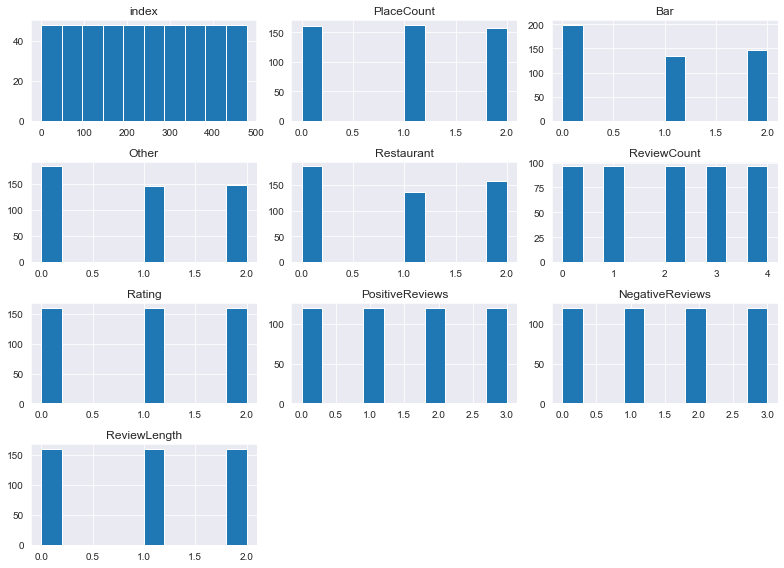

In [29]:
fig = plt.figure(figsize = (11,8))
ax = fig.gca()
data.hist(ax = ax)
#fig.show()
plt.tight_layout()